In [ ]:
# Example of a Conditional GAN (CGAN)
# Might be called C-DCGAN as it uses convolutions

In [ ]:
# https://jonathan-hui.medium.com/gan-a-comprehensive-review-into-the-gangsters-of-gans-part-1-95ff52455672
# https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html
# https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/

# https://www.tensorflow.org/tutorials/generative/dcgan

# https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/
# https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/

# https://machinelearningmastery.com/how-to-train-a-progressive-growing-gan-in-keras-for-synthesizing-faces/
# https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.layers import Reshape, Flatten, LeakyReLU, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [ ]:
# Constants
NROWS = 28
NCOLS = 28
NCHAN = 1

z_dim = 128
n_classes = 10

# Discriminator

In [ ]:
def create_discriminator(NROWS, NCOLS, NCHAN):
  model = Sequential()
  model.add(Input(shape=(NROWS, NCOLS, NCHAN + 1)))
  
  model.add(Conv2D(128, 3, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, 3, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, 3, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))

  return model

Number of parameters: 299,649


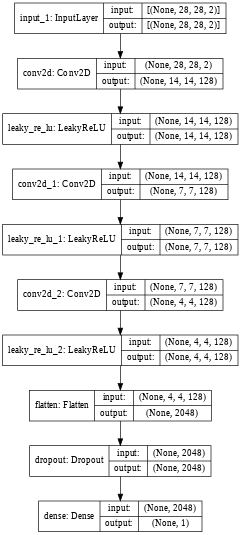

In [ ]:
disc = create_discriminator(NROWS, NCOLS, NCHAN)
print(f"Number of parameters: {disc.count_params():,}")
plot_model(disc, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
def create_cdiscriminator(NROWS, NCOLS, NCHAN, n_classes):
  img = Input(shape=(NROWS, NCOLS, NCHAN), name='x_INPUT')

  c = Input(shape=(1, ), name='c_INPUT')
  c_embedding = Embedding(n_classes, NROWS * NCOLS * NCHAN, input_length=1)(c)
  c_embedding = Reshape((NROWS, NCOLS, NCHAN))(c_embedding)

  concatenated = Concatenate(axis=-1)([img, c_embedding])

  discriminator = create_discriminator(NROWS, NCOLS, NCHAN)
  y = discriminator(concatenated)

  # Model
  model = Model([img, c], y)
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

  return model

Number of parameters: 307,489


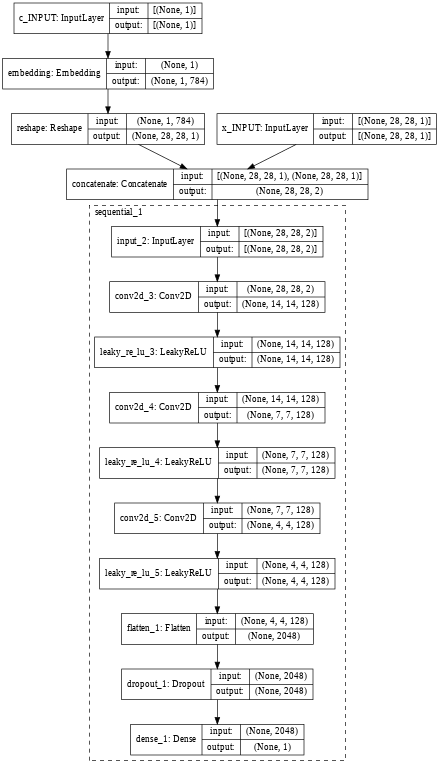

In [ ]:
cdisc = create_cdiscriminator(NROWS, NCOLS, NCHAN, 10)
print(f"Number of parameters: {cdisc.count_params():,}")
plot_model(cdisc, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

# Generator

In [ ]:
def create_generator(z_dim):
  model = Sequential()
  model.add(Input(shape=(4, 4, z_dim + 1,)))

  model.add(Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, 3))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, 4, strides=2, padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(1, 7, padding='same', activation='tanh'))

  return model

Number of parameters: 942,721


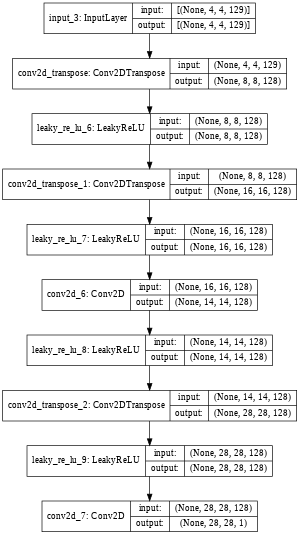

In [ ]:
gene = create_generator(z_dim)
print(f"Number of parameters: {gene.count_params():,}")
plot_model(gene, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
def create_cgenerator(z_dim, n_classes):
  z_in = Input(shape=(z_dim, ), name='z_INPUT')
  z = Dense(4 * 4 * z_dim)(z_in)
  z = LeakyReLU(0.2)(z)
  z = Reshape((4, 4, z_dim))(z)

  c_in = Input(shape=(1, ), name='c_INPUT')
  c = Embedding(n_classes, z_dim, input_length=1)(c_in)
  c = Dense(4 * 4)(c)
  c = Reshape((4, 4, 1))(c)

  concatenated = Concatenate(axis=-1)([z, c])

  generator = create_generator(z_dim)
  c_img = generator(concatenated) # x_hat

  return Model([z_in, c_in], c_img)

Number of parameters: 1,210,257


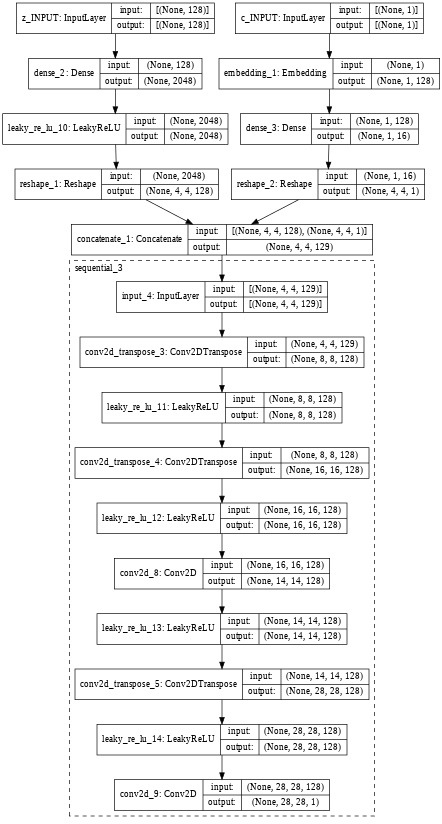

In [ ]:
cgene = create_cgenerator(z_dim, n_classes)
print(f"Number of parameters: {cgene.count_params():,}")
plot_model(cgene, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
del disc, cdisc, gene, cgene

# Full CGAN

In [ ]:
def create_cgan(cgenerator, cdiscriminator):
  cdiscriminator.trainable = False

  gen_noise, gen_label = cgenerator.input #(None, 128) and (None, 1)
  gen_output = cgenerator.output #(None, 28, 28, 1)
  
  gan_output = cdiscriminator([gen_output, gen_label])
  
  model = Model([gen_noise, gen_label], gan_output)
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
  
  return model

Number of parameters: 1,517,746


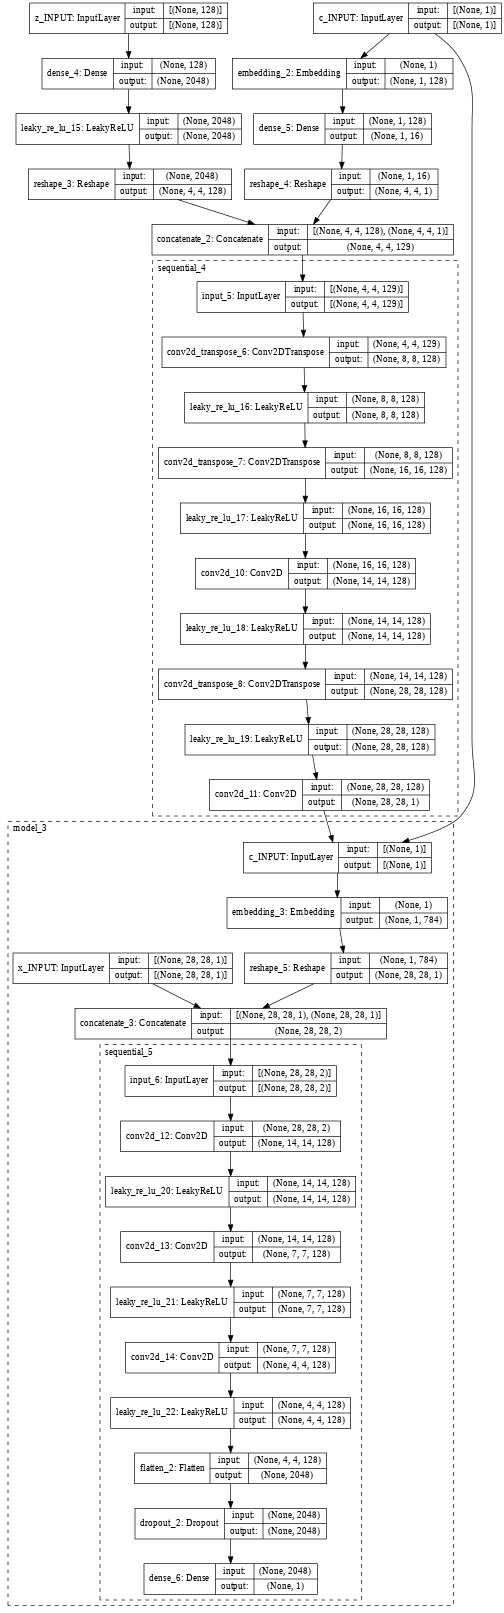

In [ ]:
cgene = create_cgenerator(z_dim, n_classes)
cdisc = create_cdiscriminator(NROWS, NCOLS, NCHAN, 10)
CGAN = create_cgan(cgene, cdisc)
print(f"Number of parameters: {CGAN.count_params():,}")
plot_model(CGAN, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=48)

In [ ]:
def train(X, c, params):
  # Unzip parameters
  n_epochs = params['n_epochs']
  batch_size = params['batch_size']
  sample_interval = params['sample_interval']
  z_dim = params['z_dim']
  n_classes = params['n_classes']

  # Performance storage
  accuracies = []
  losses = []

  # Labels for real and fake images
  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for epoch in range(n_epochs + 1):
    # -- Train Discriminator
    # Get a random batch of real images and their contect (labels)
    idx = np.random.randint(0, X.shape[0], batch_size)
    imgs, contexts = X[idx], c[idx]

    # Generate a batch of fake images
    z = np.random.normal(0, 1, (batch_size, z_dim))
    gen_imgs = cgene.predict([z, contexts])

    # Training
    d_loss_real = cdisc.train_on_batch([imgs, contexts], real)
    d_loss_fake = cdisc.train_on_batch([gen_imgs, contexts], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # -- Train Generator
    # Generate a batch of noise vectors and get a batch of random contexts
    z = np.random.normal(0, 1, (batch_size, z_dim))
    contexts = np.random.randint(0, n_classes, batch_size).reshape(-1, 1)

    # Training
    g_loss = CGAN.train_on_batch([z, contexts], real)

    if (epoch % sample_interval) == 0:
      print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))

      # Save losses and accuracies so they can be plotted after training
      losses.append((d_loss[0], g_loss))
      accuracies.append(100 * d_loss[1])

      # Output sample of generated images
      sample_images(z_dim)

  return losses, accuracies

In [ ]:
def sample_images(z_dim):
  z = np.random.normal(0, 1, (2 * 5, z_dim))
  labels = np.arange(0, 10).reshape(-1, 1)

  # Generate images from random noise
  gen_imgs = cgene.predict([z, labels])
  gen_imgs = 0.5 * gen_imgs + 0.5

  ind = 0
  fig, axs = plt.subplots(2, 5, figsize=(10, 4), sharey=True, sharex=True)
  for i in range(2):
    for j in range(5):
      axs[i, j].imshow(gen_imgs[ind, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      axs[i, j].set_title("Digit: %d" % labels[ind])
      ind += 1
  plt.show()

In [ ]:
# Load data
(x_train, y_train), (_, _) = mnist.load_data()

# Rescale [0, 255] grayscale pixel values to [-1, 1]
x_train = x_train / 127.5 - 1.
x_train = np.expand_dims(x_train, axis=3)

# Turn into float32
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

print(x_train.shape)
print(y_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(60000,)


0 [D loss: 0.705331, acc.: 6.64%] [G loss: 0.691910]


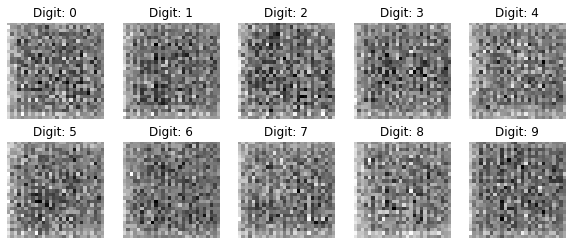

1000 [D loss: 0.000020, acc.: 100.00%] [G loss: 11.047913]


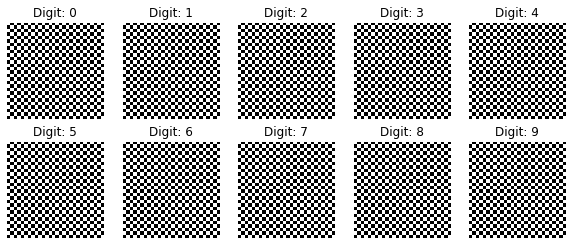

2000 [D loss: 0.000315, acc.: 100.00%] [G loss: 8.829889]


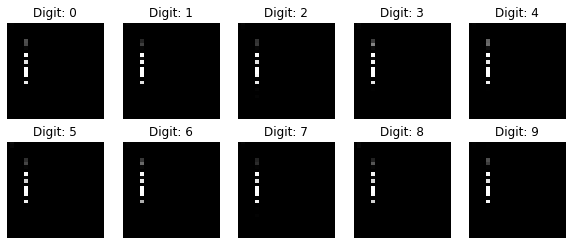

3000 [D loss: 0.000126, acc.: 100.00%] [G loss: 11.285757]


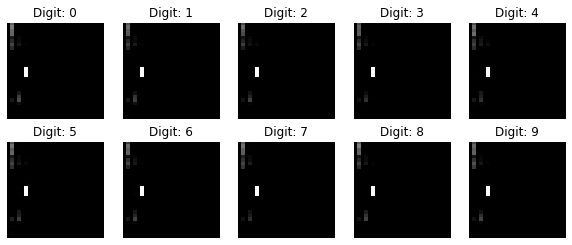

4000 [D loss: 6.852969, acc.: 0.39%] [G loss: 0.223624]


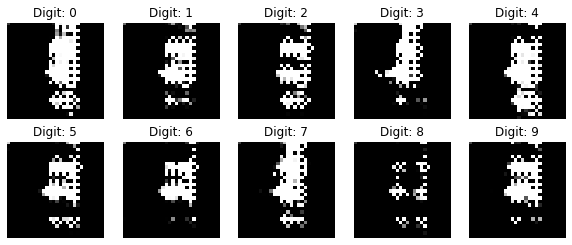

5000 [D loss: 0.626475, acc.: 65.23%] [G loss: 1.036751]


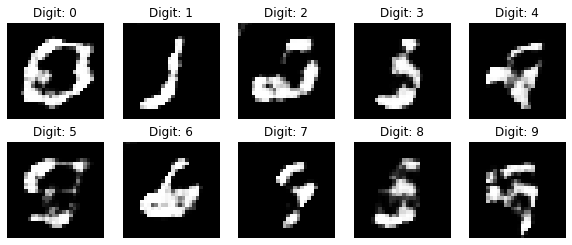

6000 [D loss: 0.593999, acc.: 70.31%] [G loss: 1.111051]


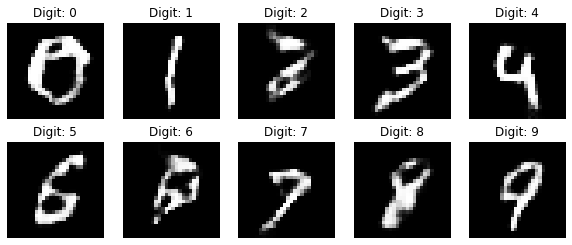

7000 [D loss: 0.595740, acc.: 66.80%] [G loss: 1.065678]


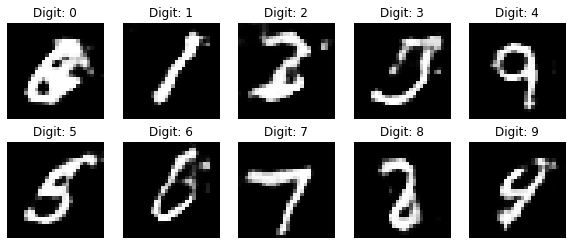

8000 [D loss: 0.588060, acc.: 66.02%] [G loss: 1.233765]


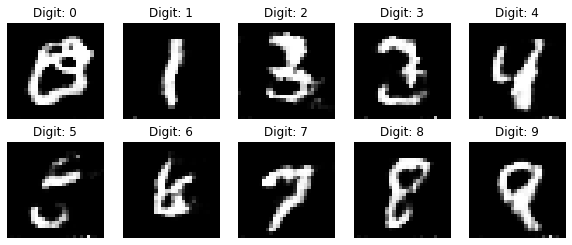

9000 [D loss: 0.466926, acc.: 78.52%] [G loss: 1.774405]


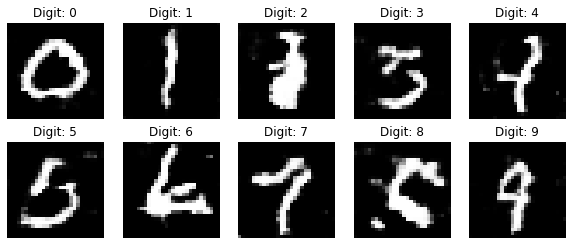

10000 [D loss: 0.383519, acc.: 87.11%] [G loss: 1.820064]


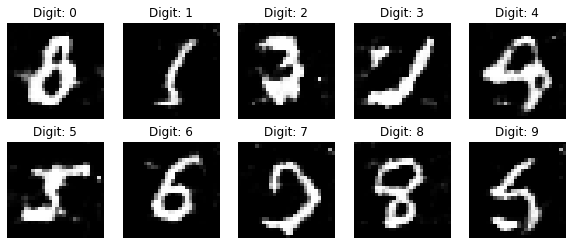

11000 [D loss: 0.523611, acc.: 72.66%] [G loss: 1.748622]


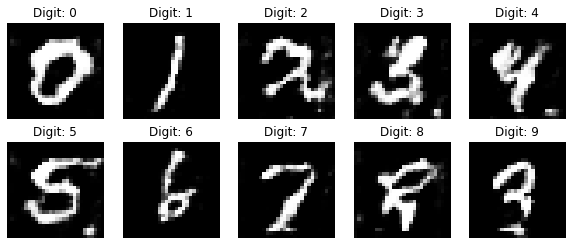

12000 [D loss: 0.422005, acc.: 82.81%] [G loss: 1.924090]


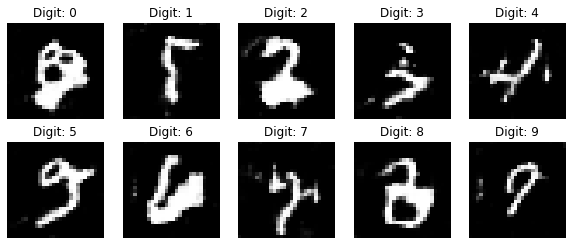

13000 [D loss: 0.352335, acc.: 85.94%] [G loss: 2.216650]


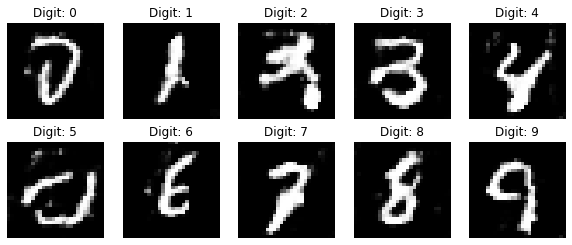

14000 [D loss: 0.290495, acc.: 89.84%] [G loss: 2.525608]


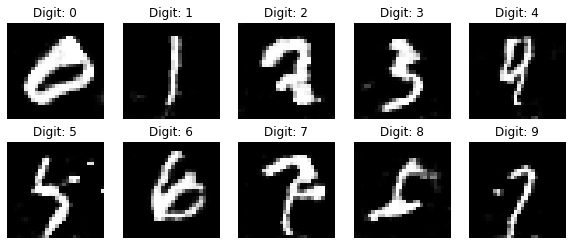

15000 [D loss: 0.341330, acc.: 86.72%] [G loss: 2.140873]


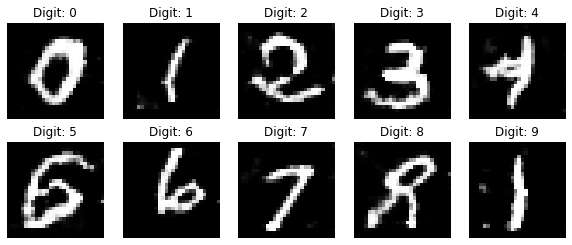

16000 [D loss: 0.448180, acc.: 80.08%] [G loss: 1.933010]


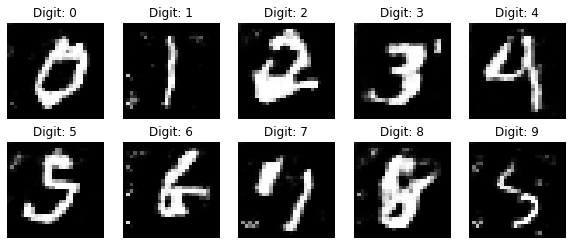

17000 [D loss: 0.352464, acc.: 84.77%] [G loss: 2.461653]


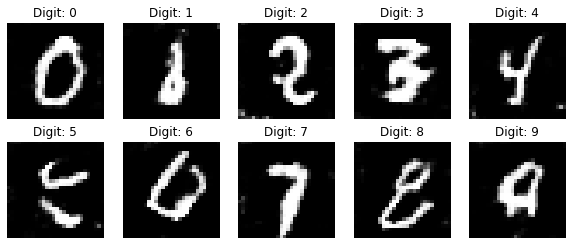

18000 [D loss: 0.349268, acc.: 85.94%] [G loss: 2.574011]


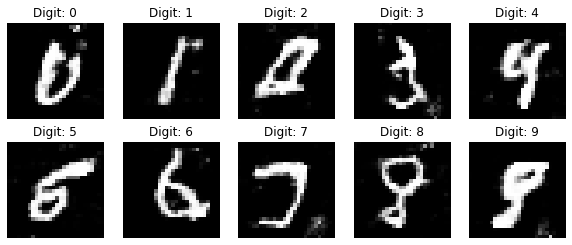

19000 [D loss: 0.256967, acc.: 90.62%] [G loss: 2.724937]


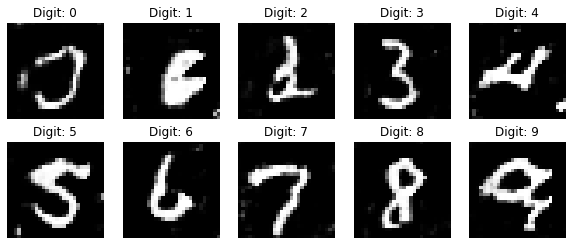

20000 [D loss: 0.343624, acc.: 88.67%] [G loss: 2.571023]


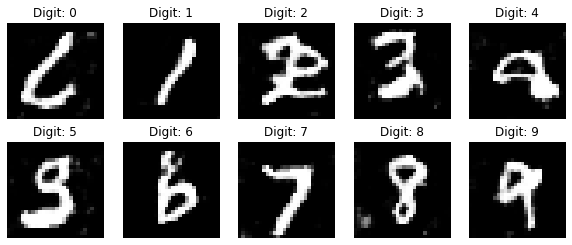

In [ ]:
# Set some hyperparameters
params = {
    'n_epochs': 20000,
    'batch_size': 128,
    'sample_interval': 1000,
    'z_dim': z_dim,
    'n_classes': n_classes
}

# Train the CGAN for the specified number of iterations
losses, accuracies = train(x_train, y_train, params)

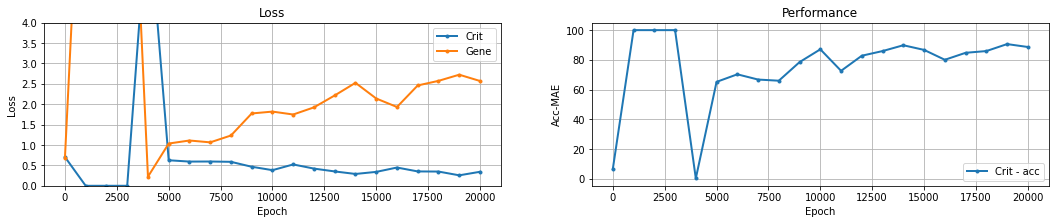

In [ ]:
# Plot loss
losses = np.array(losses)
accuracies = np.array(accuracies)

plt.figure(figsize=(18, 3))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(range(1, params['n_epochs']+2, params['sample_interval']), losses[:, 0], label='Crit', marker='.', linewidth=2)
plt.plot(range(1, params['n_epochs']+2, params['sample_interval']), losses[:, 1], label='Gene', marker='.', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim((0, 4))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Performance')
plt.plot(range(1, params['n_epochs']+2, params['sample_interval']), accuracies, label='Crit - acc', marker='.', linewidth=2)
#plt.plot(range(1, params['n_epochs']+2, params['sample_interval']), accuracies[:, 1], label='Gene - mae', marker='.', linewidth=2)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Acc-MAE')
plt.grid(True)

plt.show()